# Neural Networks for Classifications

In [1]:
import pandas as pd

In [ ]:
pseudo_df = pd.read_csv("../Datasets/pseudo_data.csv")

In [3]:
def create_pres(row):
    if row['LOCATION_TYPE'] == 'presence':
        return 1
    else:
        return 0

In [4]:
pseudo_df['presence'] = pseudo_df.apply(create_pres, axis=1)

In [5]:
pseudo_df = pseudo_df.drop(columns="LOCATION_TYPE")

In [6]:
pseudo_df

,X,Y,presence
0,-52.380000,-32.210000,1
1,-52.310000,-31.560000,1
2,-55.630000,-30.800000,1
3,-51.320000,-30.370000,1
4,-54.370000,-30.340000,1
...,...,...,...
10052,-57.046101,-14.213489,0
10053,-44.075391,-21.609520,0
10054,-55.864332,-5.483938,0
10055,-70.321079,-7.362527,0


# BNN

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as  pd

# Train-Test Split

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

X = pseudo_df[["X", "Y"]].values.astype(np.float32)
y = pseudo_df["presence"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y
)


train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


In [89]:
X_train

array([[-49.525986, -10.578374],
       [-53.51    , -20.58    ],
       [-51.      , -18.6     ],
       ...,
       [-59.44345 , -16.026592],
       [-60.175133, -14.181677],
       [-61.11    ,  -6.79    ]], dtype=float32)

# TRAINING A CLASSIC NEURAL NETWORK 

In [90]:
class VanillaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


# BINARY CROSS-ENTROPY LOSS

In [91]:
model = VanillaNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()  


# NN TRAIN

In [92]:

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

best_model_state = None

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = loss_fn(preds, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = loss_fn(val_preds, y_test_tensor.view(-1, 1)).item()
        val_binary_preds = (val_preds > 0.5).int().squeeze()
        val_acc = (val_binary_preds == y_test_tensor.int()).float().mean().item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

   
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


if best_model_state:
    model.load_state_dict(best_model_state)


Epoch 1 | Train Loss: 63.0642 | Val Loss: 0.6184 | Val Acc: 0.6288
Epoch 2 | Train Loss: 59.1409 | Val Loss: 0.5959 | Val Acc: 0.6713
Epoch 3 | Train Loss: 56.0030 | Val Loss: 0.5901 | Val Acc: 0.6817
Epoch 4 | Train Loss: 54.0808 | Val Loss: 0.5631 | Val Acc: 0.6996
Epoch 5 | Train Loss: 52.5855 | Val Loss: 0.5385 | Val Acc: 0.7706
Epoch 6 | Train Loss: 49.3185 | Val Loss: 0.4979 | Val Acc: 0.7957
Epoch 7 | Train Loss: 48.2587 | Val Loss: 0.5743 | Val Acc: 0.6938
Epoch 8 | Train Loss: 44.9300 | Val Loss: 0.4581 | Val Acc: 0.8088
Epoch 9 | Train Loss: 43.5557 | Val Loss: 0.4621 | Val Acc: 0.7808
Epoch 10 | Train Loss: 42.8873 | Val Loss: 0.4920 | Val Acc: 0.7700
Epoch 11 | Train Loss: 42.4215 | Val Loss: 0.4568 | Val Acc: 0.7761
Epoch 12 | Train Loss: 42.1098 | Val Loss: 0.4389 | Val Acc: 0.7967
Epoch 13 | Train Loss: 41.8951 | Val Loss: 0.4353 | Val Acc: 0.8161
Epoch 14 | Train Loss: 42.0694 | Val Loss: 0.4693 | Val Acc: 0.7746
Epoch 15 | Train Loss: 42.1686 | Val Loss: 0.4482 | Val A

# evaluation

In [93]:

model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    binary_preds = (test_preds > 0.5).int().squeeze()

from sklearn.metrics import classification_report

y_true = y_test_tensor.numpy()
y_pred = binary_preds.numpy()

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80      3500
         1.0       0.85      0.67      0.75      3540

    accuracy                           0.78      7040
   macro avg       0.79      0.78      0.77      7040
weighted avg       0.79      0.78      0.77      7040



In [94]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Confusion Matrix:
[[3094  406]
 [1173 2367]]
Accuracy:  0.7757
Precision: 0.8536
Recall:    0.6686
F1 Score:  0.7499


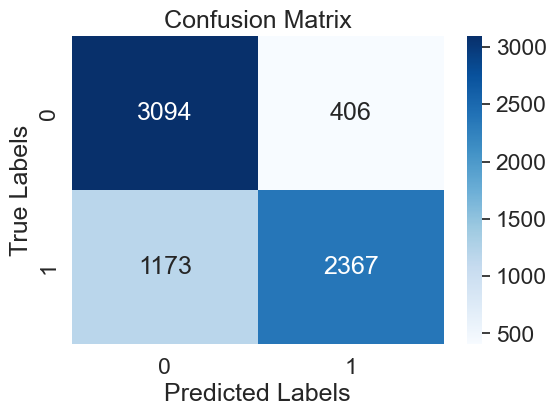

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# NN WITH COVARIATES

In [15]:
! pip install geopandas


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: C:\Users\dzaik\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [16]:
! pip install rioxarray


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: C:\Users\dzaik\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [17]:
! pip install earthpy


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: C:\Users\dzaik\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [96]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr

import earthpy as et


sns.set(font_scale=1.5, style="white")

In [97]:
import rasterio

raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    print(src.crs)


None


In [98]:
from rasterio.crs import CRS
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    pseudo_df,
    geometry=gpd.points_from_xy(pseudo_df['X'], pseudo_df['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["water_occurrence"] = values

In [99]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence"]].shape)


GeoDataFrame CRS: EPSG:4326
(10057, 3)


In [100]:
gdf.head()

,X,Y,presence,cluster_id,geometry,water_occurrence
0,-52.38,-32.21,1,3,POINT (-52.38 -32.21),16.0
1,-52.31,-31.56,1,3,POINT (-52.31 -31.56),28.0
2,-55.63,-30.80,1,3,POINT (-55.63 -30.8),3.0
3,-51.32,-30.37,1,3,POINT (-51.32 -30.37),62.0
4,-54.37,-30.34,1,3,POINT (-54.37 -30.34),16.0


In [101]:
brazil_data_with_water = pd.DataFrame(gdf.drop(columns="geometry"))
print(brazil_data_with_water.head())

       X      Y  presence  cluster_id  water_occurrence
0 -52.38 -32.21         1           3              16.0
1 -52.31 -31.56         1           3              28.0
2 -55.63 -30.80         1           3               3.0
3 -51.32 -30.37         1           3              62.0
4 -54.37 -30.34         1           3              16.0


In [102]:
brazil_data_with_water.shape

(10057, 5)

In [103]:

gdf = gpd.GeoDataFrame(
    brazil_data_with_water,
    geometry=gpd.points_from_xy(brazil_data_with_water['X'], brazil_data_with_water['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_annual_mean_temp_2020_crop_mask.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["annual_mean_temp"] = values

In [104]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence", "annual_mean_temp"]].head())


GeoDataFrame CRS: EPSG:4326
       X      Y  water_occurrence  annual_mean_temp
0 -52.38 -32.21              16.0         18.891666
1 -52.31 -31.56              28.0         18.703333
2 -55.63 -30.80               3.0         18.783333
3 -51.32 -30.37              62.0         19.741667
4 -54.37 -30.34              16.0         19.441666


In [105]:
new_brazil_data = pd.DataFrame(gdf.drop(columns="geometry"))

In [106]:
new_brazil_data.head()

,X,Y,presence,cluster_id,water_occurrence,annual_mean_temp
0,-52.38,-32.21,1,3,16.0,18.891666
1,-52.31,-31.56,1,3,28.0,18.703333
2,-55.63,-30.80,1,3,3.0,18.783333
3,-51.32,-30.37,1,3,62.0,19.741667
4,-54.37,-30.34,1,3,16.0,19.441666


In [107]:
def extract_raster_values(df, raster_path, column_name, x_col='X', y_col='Y', crs_epsg=4326):
    """
    Extracts raster values at each point location from a DataFrame and adds them as a new column.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with coordinate columns.
    - raster_path (str): Path to the raster file (.asc).
    - column_name (str): Name of the new column to add with extracted values.
    - x_col (str): Name of the longitude column.
    - y_col (str): Name of the latitude column.
    - crs_epsg (int): EPSG code of the coordinate reference system (default: 4326).

    Returns:
    - pd.DataFrame: DataFrame with the new column added.
    """
    
    # Converting DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[x_col], df[y_col]),
        crs=f"EPSG:{crs_epsg}"
    )
    
    # Opening the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs if src.crs is not None else CRS.from_epsg(crs_epsg)
        gdf = gdf.to_crs(raster_crs)
        coords = [(point.x, point.y) for point in gdf.geometry]
        values = [val[0] for val in src.sample(coords)]
    
    # Adding the extracted raster values as a new column
    gdf[column_name] = values
    
    # Returning as a regular DataFrame
    return pd.DataFrame(gdf.drop(columns="geometry"))


In [108]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_urban_built_up_earthenv.asc"
brazil_data_with_eath = extract_raster_values(new_brazil_data, raster_path, "urban_built_up_eartnev")


brazil_data_with_eath[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev"]].head()


,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev
0,-52.38,-32.21,16.0,18.891666,0.0
1,-52.31,-31.56,28.0,18.703333,0.0
2,-55.63,-30.80,3.0,18.783333,0.0
3,-51.32,-30.37,62.0,19.741667,0.0
4,-54.37,-30.34,16.0,19.441666,0.0


In [109]:
brazil_data_with_eath.shape

(10057, 7)

In [110]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_Croplands_2019.asc"
brazil_data_with_crop = extract_raster_values(brazil_data_with_eath, raster_path, "croplands")

brazil_data_with_crop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands
0,-52.38,-32.21,16.0,18.891666,0.0,0.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0


In [111]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_pop_density_2020.asc"
brazil_data_with_pop = extract_raster_values(brazil_data_with_crop, raster_path, "pop_density")


brazil_data_with_pop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853


In [112]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_elevation_crop_mask.asc"
brazil_data_with_crop_mask = extract_raster_values(brazil_data_with_pop, raster_path, "crop_mask")


brazil_data_with_crop_mask[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0


In [113]:
brazil_data_with_crop_mask.head()

,X,Y,presence,cluster_id,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-52.38,-32.21,1,3,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-52.31,-31.56,1,3,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-55.63,-30.80,1,3,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-51.32,-30.37,1,3,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-54.37,-30.34,1,3,16.0,19.441666,0.0,9.0,2.771853,102.0


In [114]:
new_brazil_data_cov = pd.DataFrame(gdf.drop(columns="geometry"))

In [115]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_precipitation_mean_2023_crop_mask.asc"
brazil_data_with_precip = extract_raster_values(brazil_data_with_crop_mask, raster_path, "precipitation_mean")

brazil_data_with_precip[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask", "precipitation_mean"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [116]:
brazil_data_with_precip.head()

,X,Y,presence,cluster_id,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,1,3,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,1,3,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,1,3,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,1,3,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,1,3,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [117]:
brazil_cov_df = brazil_data_with_precip.drop(columns = ["urban_built_up_eartnev"])

In [118]:
brazil_cov_df = brazil_cov_df.drop(columns = ["croplands"])

In [119]:
brazil_cov_df = brazil_cov_df.drop(columns = ["crop_mask"])

In [120]:
brazil_cov_df.head()

,X,Y,presence,cluster_id,water_occurrence,annual_mean_temp,pop_density,precipitation_mean
0,-52.38,-32.21,1,3,16.0,18.891666,0.588867,3.859667
1,-52.31,-31.56,1,3,28.0,18.703333,11.132005,4.289240
2,-55.63,-30.80,1,3,3.0,18.783333,0.204499,4.988751
3,-51.32,-30.37,1,3,62.0,19.741667,0.492814,4.020680
4,-54.37,-30.34,1,3,16.0,19.441666,2.771853,5.230323


In [121]:
brazil_cov_df = brazil_data_with_precip.copy()

In [122]:
brazil_cov_df.head()

,X,Y,presence,cluster_id,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,1,3,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,1,3,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,1,3,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,1,3,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,1,3,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [123]:
# Count how many times -9999 or -9999.0 appear per column
unknown_counts = (brazil_data_with_precip == -9999).sum() + (brazil_data_with_precip == -9999.0).sum() +  (brazil_data_with_precip ==-9999.000000 ).sum()

# Show only columns where such values exist
unknown_counts = unknown_counts[unknown_counts > 0].sort_values(ascending=False)

print("Columns with -9999 values:")
print(unknown_counts)


Columns with -9999 values:
pop_density               1836
annual_mean_temp          1794
precipitation_mean        1791
crop_mask                 1770
water_occurrence          1752
croplands                 1743
urban_built_up_eartnev    1740
dtype: int64


In [124]:

brazil_data_with_precip.replace([-9999, -9999.0, -9999.000000], np.nan, inplace=True)


In [125]:
cleaned_data = brazil_data_with_precip.fillna(brazil_data_with_precip.mean(numeric_only=True))


In [126]:
cleaned_data.head()

,X,Y,presence,cluster_id,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,1,3,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,1,3,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,1,3,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,1,3,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,1,3,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [127]:

features = ['X', 'Y', 'water_occurrence', 'annual_mean_temp', 'pop_density', 'precipitation_mean', 'urban_built_up_eartnev', 'croplands', 'crop_mask']


# features = ['water_occurrence', 'annual_mean_temp', 'pop_density', 'precipitation_mean']

X = cleaned_data[features].values
y = cleaned_data['presence'].values


In [153]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# when scaling data make sure to scale the test data with the same scaler



In [154]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [155]:
 X_train.shape[1]

9

In [156]:
input_dim = X_train.shape[1]  

class VanillaNet(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [157]:
input_dim

9

In [158]:
model = VanillaNet(input_dim=input_dim)


In [159]:
import numpy as np
np.bincount(y)


array([5000, 5057])

In [160]:
import numpy as np

# Before split
print("Before split:", np.bincount(y))

# After split
print("Train split:", np.bincount(y_train))
print("Test split:", np.bincount(y_test))


Before split: [5000 5057]
Train split: [1500 1517]
Test split: [3500 3540]


In [161]:
model = VanillaNet(input_dim=input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()  


In [162]:


patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

best_model_state = None

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = loss_fn(preds, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = loss_fn(val_preds, y_test_tensor.view(-1, 1)).item()
        val_binary_preds = (val_preds > 0.5).int().squeeze()
        val_acc = (val_binary_preds == y_test_tensor.int()).float().mean().item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

   
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


if best_model_state:
    model.load_state_dict(best_model_state)


Epoch 1 | Train Loss: 13.6921 | Val Loss: 0.4597 | Val Acc: 0.7940
Epoch 2 | Train Loss: 9.8643 | Val Loss: 0.4002 | Val Acc: 0.8143
Epoch 3 | Train Loss: 9.2194 | Val Loss: 0.3928 | Val Acc: 0.8075
Epoch 4 | Train Loss: 8.9901 | Val Loss: 0.3861 | Val Acc: 0.8142
Epoch 5 | Train Loss: 8.8600 | Val Loss: 0.3817 | Val Acc: 0.8230
Epoch 6 | Train Loss: 8.8117 | Val Loss: 0.3796 | Val Acc: 0.8185
Epoch 7 | Train Loss: 8.6556 | Val Loss: 0.3744 | Val Acc: 0.8251
Epoch 8 | Train Loss: 8.5461 | Val Loss: 0.3747 | Val Acc: 0.8268
Epoch 9 | Train Loss: 8.5628 | Val Loss: 0.3734 | Val Acc: 0.8232
Epoch 10 | Train Loss: 8.5934 | Val Loss: 0.3703 | Val Acc: 0.8288
Epoch 11 | Train Loss: 8.3211 | Val Loss: 0.3682 | Val Acc: 0.8300
Epoch 12 | Train Loss: 8.3021 | Val Loss: 0.3656 | Val Acc: 0.8341
Epoch 13 | Train Loss: 8.0982 | Val Loss: 0.3662 | Val Acc: 0.8290
Epoch 14 | Train Loss: 8.0293 | Val Loss: 0.3644 | Val Acc: 0.8318
Epoch 15 | Train Loss: 7.9991 | Val Loss: 0.3659 | Val Acc: 0.8307
Epo

In [163]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    binary_preds = (test_preds > 0.5).int().squeeze()

from sklearn.metrics import classification_report

y_true = y_test_tensor.numpy()
y_pred = binary_preds.numpy()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.75      0.81      3500
         1.0       0.78      0.90      0.84      3540

    accuracy                           0.82      7040
   macro avg       0.83      0.82      0.82      7040
weighted avg       0.83      0.82      0.82      7040



In [164]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Confusion Matrix:
[[2629  871]
 [ 365 3175]]
Accuracy:  0.8244
Precision: 0.7847
Recall:    0.8969
F1 Score:  0.8371


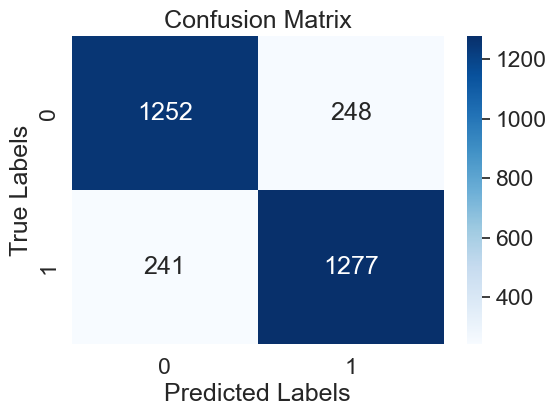

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Block Testing

In [62]:
from sklearn.cluster import KMeans

# We cluster using only X and Y
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pseudo_df['cluster_id'] = kmeans.fit_predict(pseudo_df[['X', 'Y']])


In [63]:
print(pseudo_df.groupby('cluster_id')['presence'].value_counts())


cluster_id  presence
0           1           2004
            0            158
1           1           1851
            0            893
2           0           2557
            1            266
3           0           1392
            1            936
Name: count, dtype: int64


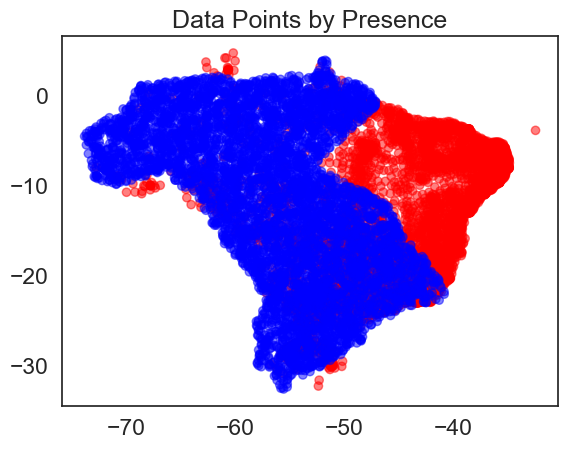

In [64]:
import matplotlib.pyplot as plt
plt.scatter(pseudo_df['X'], pseudo_df['Y'], c=pseudo_df['presence'], cmap='bwr', alpha=0.5)
plt.title('Data Points by Presence')
plt.show()

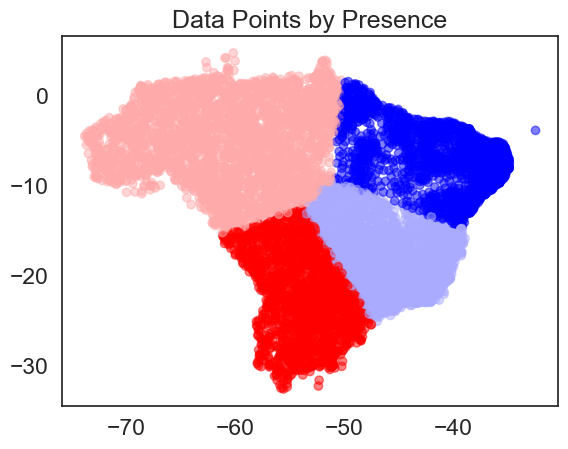

In [65]:
import matplotlib.pyplot as plt
plt.scatter(pseudo_df['X'], pseudo_df['Y'], c=pseudo_df['cluster_id'], cmap='bwr', alpha=0.5)
plt.title('Data Points by Presence')
plt.show()

In [66]:
train_clusters = [1, 3]
val_clusters = [0]
test_clusters = [2]

train_df = pseudo_df[pseudo_df['cluster_id'].isin(train_clusters)]
val_df = pseudo_df[pseudo_df['cluster_id'].isin(val_clusters)]
test_df = pseudo_df[pseudo_df['cluster_id'].isin(test_clusters)]


In [67]:
train_df = pseudo_df[pseudo_df['cluster_id'].isin(train_clusters)]
val_df = pseudo_df[pseudo_df['cluster_id'].isin(val_clusters)]
test_df = pseudo_df[pseudo_df['cluster_id'].isin(test_clusters)]

In [68]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt

# === Check class distribution ===
print("Train class distribution:\n", train_df['presence'].value_counts())
print("Validation class distribution (before balancing):\n", val_df['presence'].value_counts())
print("Test class distribution:\n", test_df['presence'].value_counts())

# === Balance validation set ===
# Subsample to match the minority class (class 0 with 158 samples)
val_df_0 = val_df[val_df['presence'] == 0]
val_df_1 = val_df[val_df['presence'] == 1].sample(n=158, random_state=42)  # Downsample class 1
val_df_balanced = pd.concat([val_df_0, val_df_1]).sample(frac=1, random_state=42)  # Shuffle
print("Validation class distribution (after balancing):\n", val_df_balanced['presence'].value_counts())

# === Visualize data to check separability ===
plt.scatter(train_df['X'], train_df['Y'], c=train_df['presence'], cmap='bwr', alpha=0.5, label='Train')
plt.scatter(val_df_balanced['X'], val_df_balanced['Y'], c=val_df_balanced['presence'], cmap='bwr', marker='^', alpha=0.5, label='Validation')
plt.scatter(test_df['X'], test_df['Y'], c=test_df['presence'], cmap='bwr', marker='s', alpha=0.5, label='Test')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data Distribution by Presence and Split')
plt.legend()
plt.savefig('data_distribution.png')
plt.close()

# === Prepare data ===
X_train_raw = train_df[['X', 'Y']].values
X_val_raw = val_df_balanced[['X', 'Y']].values
X_test_raw = test_df[['X', 'Y']].values

y_train = train_df['presence'].astype(np.float32).values
y_val = val_df_balanced['presence'].astype(np.float32).values
y_test = test_df['presence'].astype(np.float32).values

# === Standardize ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw).astype(np.float32)
X_val = scaler.transform(X_val_raw).astype(np.float32)
X_test = scaler.transform(X_test_raw).astype(np.float32)

# === Logistic regression baseline ===
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\nLogistic Regression Baseline Report:")
print(classification_report(y_test, y_pred))

# === Compute pos_weight ===
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight_value = n_neg / n_pos
if pos_weight_value > 100:
    pos_weight_value = np.log1p(pos_weight_value)
print(f"Positive weight: {pos_weight_value:.2f}")

# === Balanced sampler ===
class_counts = pd.Series(y_train).value_counts().to_dict()
sample_weights = [1.0 / class_counts[label] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# === Datasets and loaders ===
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)

# === Define focal loss ===
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=1.0):  # Reduced gamma for better balance
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

# === Define neural net ===
class VanillaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model = VanillaNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = FocalLoss(alpha=pos_weight_value, gamma=1.0)

# === Training loop ===
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 10
best_model_state = None

for epoch in range(100):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch).squeeze()
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = loss_fn(val_outputs, y_val_tensor).item()
        val_probs = torch.sigmoid(val_outputs)
        val_preds = (val_probs > 0.5).int()
        val_acc = (val_preds == y_val_tensor.int()).float().mean().item()
        # Compute per-class F1 scores
        val_f1_0 = f1_score(y_val, val_preds, pos_label=0)
        val_f1_1 = f1_score(y_val, val_preds, pos_label=1)

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1 (Class 0): {val_f1_0:.4f} | Val F1 (Class 1): {val_f1_1:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# === Final test evaluation ===
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    test_probs = torch.sigmoid(test_outputs).cpu().numpy()

# === Precision-recall curve and optimal threshold ===
precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
ap = average_precision_score(y_test, test_probs)

# Find optimal threshold (maximizing F1 score)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")

plt.plot(recall, precision, label=f'AP={ap:.2f}')
plt.axvline(recall[optimal_idx], linestyle='--', color='r', label=f'Optimal Threshold={optimal_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('precision_recall_curve.png')
plt.close()

# === Classification report at multiple thresholds ===
print("\nNeural Network Report :")
test_preds = (test_probs > optimal_threshold).astype(int)
print(classification_report(y_test, test_preds))

print("\nNeural Network Report (Threshold=0.3):")
test_preds_low = (test_probs > 0.3).astype(int)
print(classification_report(y_test, test_preds_low))

# === Histogram of test probabilities ===
plt.hist(test_probs, bins=50)
plt.title('Distribution of Test Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.savefig('test_probabilities_histogram.png')
plt.close()

# === Visualize decision boundary ===
def plot_decision_boundary(model, X, y, scaler, filename='decision_boundary.png'):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid).astype(np.float32)
    grid_tensor = torch.tensor(grid_scaled)
    
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(grid_tensor)).cpu().numpy()
    probs = probs.reshape(xx.shape)
    
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.3, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.8)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Decision Boundary')
    plt.savefig(filename)
    plt.close()

plot_decision_boundary(model, X_test_raw, y_test, scaler)

Train class distribution:
 presence
1    2787
0    2285
Name: count, dtype: int64
Validation class distribution (before balancing):
 presence
1    2004
0     158
Name: count, dtype: int64
Test class distribution:
 presence
0    2557
1     266
Name: count, dtype: int64
Validation class distribution (after balancing):
 presence
1    158
0    158
Name: count, dtype: int64

Logistic Regression Baseline Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2557
         1.0       0.00      0.00      0.00       266

    accuracy                           0.91      2823
   macro avg       0.45      0.50      0.48      2823
weighted avg       0.82      0.91      0.86      2823

Positive weight: 0.82


c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1 | Train Loss: 38.7764 | Val Loss: 0.1275 | Val Acc: 0.8797 | Val F1 (Class 0): 0.8927 | Val F1 (Class 1): 0.8633
Epoch 2 | Train Loss: 37.6234 | Val Loss: 0.1226 | Val Acc: 0.8766 | Val F1 (Class 0): 0.8901 | Val F1 (Class 1): 0.8592
Epoch 3 | Train Loss: 37.1518 | Val Loss: 0.1165 | Val Acc: 0.8892 | Val F1 (Class 0): 0.9003 | Val F1 (Class 1): 0.8754
Epoch 4 | Train Loss: 36.6886 | Val Loss: 0.1218 | Val Acc: 0.8829 | Val F1 (Class 0): 0.8952 | Val F1 (Class 1): 0.8674
Epoch 5 | Train Loss: 35.6291 | Val Loss: 0.1057 | Val Acc: 0.8892 | Val F1 (Class 0): 0.9003 | Val F1 (Class 1): 0.8754
Epoch 6 | Train Loss: 35.6873 | Val Loss: 0.1017 | Val Acc: 0.9082 | Val F1 (Class 0): 0.9159 | Val F1 (Class 1): 0.8990
Epoch 7 | Train Loss: 36.3337 | Val Loss: 0.1019 | Val Acc: 0.9051 | Val F1 (Class 0): 0.9133 | Val F1 (Class 1): 0.8951
Epoch 8 | Train Loss: 35.9150 | Val Loss: 0.0958 | Val Acc: 0.9209 | Val F1 (Class 0): 0.9267 | Val F1 (Class 1): 0.9141
Epoch 9 | Train Loss: 35.3831 | 

c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# gdgdwh

# heyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Get raw outputs
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    test_probs = torch.sigmoid(test_outputs).cpu().numpy()

# Check basic stats
print("Mean probability:", np.mean(test_probs))
print("Min probability:", np.min(test_probs))
print("Max probability:", np.max(test_probs))
print("Sample probabilities:", test_probs[:20])


Mean probability: 0.113050275
Min probability: 0.027678952
Max probability: 0.27151054
Sample probabilities: [0.2018741  0.19194153 0.23578972 0.20974758 0.17752425 0.2495104
 0.19520247 0.16510431 0.17986397 0.25327036 0.15711449 0.21546337
 0.16871485 0.23343848 0.2579876  0.1705505  0.15202764 0.24189508
 0.25753123 0.1488148 ]



Logistic Regression Baseline Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2557
         1.0       0.00      0.00      0.00       266

    accuracy                           0.91      2823
   macro avg       0.45      0.50      0.48      2823
weighted avg       0.82      0.91      0.86      2823



c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1 | Train Loss: 86.4681 | Val Loss: 0.6987 | Val Acc: 0.6170
Epoch 2 | Train Loss: 82.2343 | Val Loss: 0.4608 | Val Acc: 0.7470
Epoch 3 | Train Loss: 81.0700 | Val Loss: 0.1521 | Val Acc: 0.9084
Epoch 4 | Train Loss: 78.2880 | Val Loss: 0.1909 | Val Acc: 0.8853
Epoch 5 | Train Loss: 77.5532 | Val Loss: 0.1378 | Val Acc: 0.9126
Epoch 6 | Train Loss: 75.8105 | Val Loss: 0.1616 | Val Acc: 0.8950
Epoch 7 | Train Loss: 76.0677 | Val Loss: 0.1677 | Val Acc: 0.9093
Epoch 8 | Train Loss: 77.4574 | Val Loss: 0.1514 | Val Acc: 0.9107
Epoch 9 | Train Loss: 76.8717 | Val Loss: 0.1939 | Val Acc: 0.9107
Epoch 10 | Train Loss: 74.7940 | Val Loss: 0.1952 | Val Acc: 0.9093
Epoch 11 | Train Loss: 75.0682 | Val Loss: 0.2049 | Val Acc: 0.9130
Epoch 12 | Train Loss: 74.5060 | Val Loss: 0.2256 | Val Acc: 0.9098
Epoch 13 | Train Loss: 74.8132 | Val Loss: 0.2118 | Val Acc: 0.9084
Epoch 14 | Train Loss: 74.1404 | Val Loss: 0.3371 | Val Acc: 0.9117
Epoch 15 | Train Loss: 73.0508 | Val Loss: 0.2827 | Val A

Epoch 88 | Train Loss: 69.5976 | Val Loss: 0.5493 | Val Acc: 0.9140
Epoch 89 | Train Loss: 71.3801 | Val Loss: 0.5016 | Val Acc: 0.9149
Epoch 90 | Train Loss: 68.5378 | Val Loss: 0.5066 | Val Acc: 0.9158
Epoch 91 | Train Loss: 68.7575 | Val Loss: 0.5772 | Val Acc: 0.9177
Epoch 92 | Train Loss: 69.4522 | Val Loss: 0.4855 | Val Acc: 0.9135
Epoch 93 | Train Loss: 69.4721 | Val Loss: 0.6388 | Val Acc: 0.9195
Epoch 94 | Train Loss: 70.5550 | Val Loss: 0.4154 | Val Acc: 0.9130
Epoch 95 | Train Loss: 69.1541 | Val Loss: 0.4340 | Val Acc: 0.9177
Epoch 96 | Train Loss: 71.2923 | Val Loss: 0.5944 | Val Acc: 0.9135
Epoch 97 | Train Loss: 70.6754 | Val Loss: 0.5823 | Val Acc: 0.9191
Epoch 98 | Train Loss: 71.2798 | Val Loss: 0.5345 | Val Acc: 0.9158
Epoch 99 | Train Loss: 69.8296 | Val Loss: 0.5573 | Val Acc: 0.9154
Epoch 100 | Train Loss: 68.8024 | Val Loss: 0.5274 | Val Acc: 0.9149


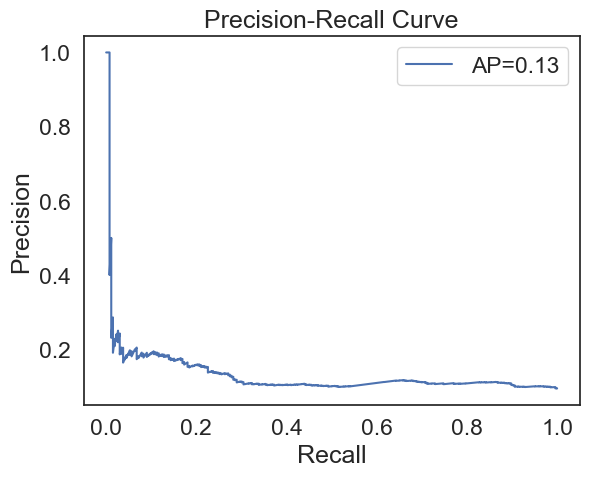


Neural Network Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2557
         1.0       1.00      0.00      0.01       266

    accuracy                           0.91      2823
   macro avg       0.95      0.50      0.48      2823
weighted avg       0.91      0.91      0.86      2823



In [70]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Prepare data ===
X_train_raw = train_df[['X', 'Y']].values
X_val_raw = val_df[['X', 'Y']].values
X_test_raw = test_df[['X', 'Y']].values

y_train = train_df['presence'].astype(np.float32).values
y_val = val_df['presence'].astype(np.float32).values
y_test = test_df['presence'].astype(np.float32).values

# === Standardize ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw).astype(np.float32)
X_val = scaler.transform(X_val_raw).astype(np.float32)
X_test = scaler.transform(X_test_raw).astype(np.float32)

# === Logistic regression baseline ===
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\nLogistic Regression Baseline Report:")
print(classification_report(y_test, y_pred))

# === Compute pos_weight ===
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight_value = n_neg / n_pos
pos_weight = torch.tensor([pos_weight_value])

# === Balanced sampler ===
class_counts = pd.Series(y_train).value_counts().to_dict()
sample_weights = [1.0 / class_counts[label] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# === Datasets and loaders ===
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)

# === Define neural net ===
class VanillaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

model = VanillaNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# === Training loop (no early stopping) ===
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(100):  # full 100 epochs
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch).squeeze()
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = loss_fn(val_outputs, y_val_tensor).item()
        val_probs = torch.sigmoid(val_outputs)
        val_preds = (val_probs > 0.5).int()
        val_acc = (val_preds == y_val_tensor.int()).float().mean().item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Track best model (optional)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

# Load best model (optional)
if best_model_state:
    model.load_state_dict(best_model_state)

# === Final test evaluation ===
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    test_probs = torch.sigmoid(test_outputs).cpu().numpy()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
ap = average_precision_score(y_test, test_probs)

plt.plot(recall, precision, label=f'AP={ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Classification report at 0.5 threshold
test_preds = (test_probs > 0.5).astype(int)
print("\nNeural Network Report:")
print(classification_report(y_test, test_preds))
